# One-qudit: High-dimensional phase estimation

In [8]:
import itertools

import equinox as eqx
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from rich.pretty import pprint

from squint.circuit import Circuit
from squint.ops.dv import DiscreteVariableState, HGate, RZGate

In [9]:
dim = 4

circuit = Circuit()

circuit.add(DiscreteVariableState(wires=(0,), n=(0,)))
circuit.add(HGate(wires=(0,)))
circuit.add(RZGate(wires=(0,), phi=0.1 * jnp.pi), "phase")
circuit.add(HGate(wires=(0,)))

params, static = eqx.partition(circuit, eqx.is_inexact_array)

print("The full circuit object:")
pprint(circuit)

print("The parameterized leaves of the Pytree:")
pprint(params)

print("The static leaves of the Pytree:")
pprint(static)

The full circuit object:


Circuit(
  dims=None,
  ops={
│   0:
│   DiscreteVariableState(wires=(0,), n=[(1.0, (0,))]),
│   1:
│   HGate(wires=(0,)),
│   'phase':
│   RZGate(wires=(0,), phi=weak_f64[]),
│   3:
│   HGate(wires=(0,))
  },
  _backend=None
)

The parameterized leaves of the Pytree:


Circuit(
  dims=None,
  ops={
│   0:
│   DiscreteVariableState(wires=(None,), n=[(None, (None,))]),
│   1:
│   HGate(wires=(None,)),
│   'phase':
│   RZGate(wires=(None,), phi=weak_f64[]),
│   3:
│   HGate(wires=(None,))
  },
  _backend=None
)

The static leaves of the Pytree:


Circuit(
  dims=None,
  ops={
│   0:
│   DiscreteVariableState(wires=(0,), n=[(1.0, (0,))]),
│   1:
│   HGate(wires=(0,)),
│   'phase':
│   RZGate(wires=(0,), phi=None),
│   3:
│   HGate(wires=(0,))
  },
  _backend=None
)

In [10]:
sim = circuit.compile(params, static, dim=dim, optimize="greedy")

get = lambda pytree: jnp.array([pytree.ops["phase"].phi])

phis = jnp.linspace(-jnp.pi, jnp.pi, 100)
params = eqx.tree_at(
    lambda pytree: pytree.ops["phase"].phi, params, jnp.expand_dims(phis, axis=1)
)

probs = eqx.filter_vmap(sim.probabilities.forward)(params)
cfims = eqx.filter_vmap(sim.probabilities.cfim, in_axes=(None, 0))(get, params)
qfims = eqx.filter_vmap(sim.amplitudes.qfim, in_axes=(None, 0))(get, params)

[Text(0.5, 0, 'Phase, $\\varphi$'),
 Text(0, 0.5, '$\\mathcal{I}_\\varphi^C$'),
 (0.0, 71.4000170743331)]

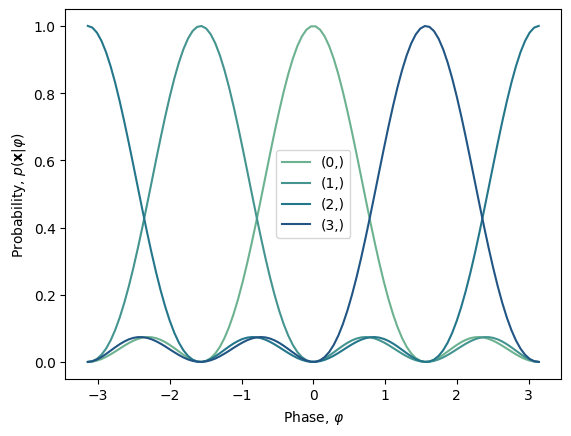

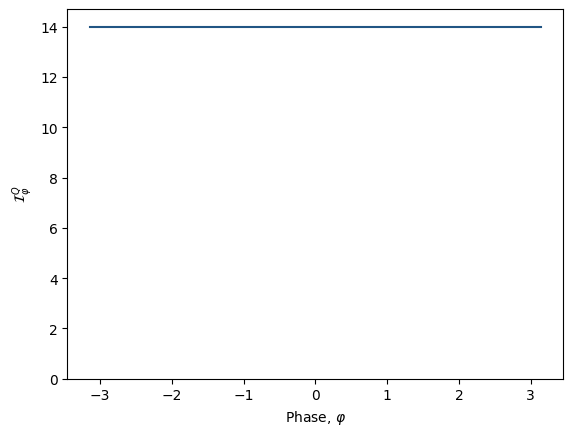

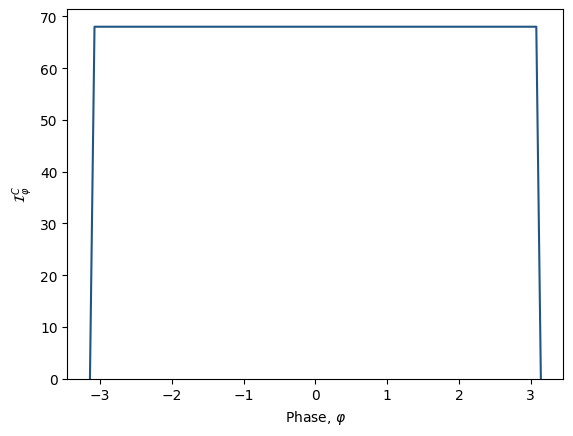

In [11]:
colors = sns.color_palette("crest", n_colors=jnp.prod(jnp.array(probs.shape[1:])))
fig, ax = plt.subplots()
for i, idx in enumerate(
    itertools.product(*[list(range(ell)) for ell in probs.shape[1:]])
):
    ax.plot(phis, probs[:, *idx], label=f"{idx}", color=colors[i])
ax.legend()
ax.set(xlabel=r"Phase, $\varphi$", ylabel=r"Probability, $p(\mathbf{x} | \varphi)$")


fig, ax = plt.subplots()
ax.plot(phis, qfims.squeeze(), color=colors[i])
ax.set(
    xlabel=r"Phase, $\varphi$",
    ylabel=r"$\mathcal{I}_\varphi^Q$",
    ylim=[0, 1.05 * jnp.max(qfims)],
)

fig, ax = plt.subplots()
ax.plot(phis, cfims.squeeze(), color=colors[i])
ax.set(
    xlabel=r"Phase, $\varphi$",
    ylabel=r"$\mathcal{I}_\varphi^C$",
    ylim=[0, 1.05 * jnp.max(cfims)],
)